### WIP example getting T and EM from GOES/XRS15 data

Based off of sswidl [goes_tem_calc.pro](https://hesperia.gsfc.nasa.gov/ssw/gen/idl/synoptic/goes/goes_tem_calc.pro)

Assumes data is the [newer reprocessed unscaled data (no 0.7 or 0.85 factors applied)](https://satdat.ngdc.noaa.gov/sem/goes/data/science/xrs/GOES_13-15_XRS_Science-Quality_Data_Readme.pdf), so consistent with XRS16+

* 23-10-21   IGH
* 
---

In [1]:
#  Import in the usual stuff
import glob
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate

from sunpy import timeseries as ts
from sunpy.net import Fido
from sunpy.net import attrs as a

In [2]:
# Assumes have downloaded data via https://github.com/ianan/xrs_example/blob/main/xrs15_example.ipynb
# Load data into timeseries
outdir='/Users/iain/sunpy/data/'
fg15=glob.glob(outdir+'*g15*20101105*.nc')
g15 = ts.TimeSeries(fg15, concatenate=True)
# Then truncate to time range interested in
trange=a.Time("2010-11-05 12:00","2010-11-05 17:00")
tg15=g15.truncate(trange.start.iso,trange.end.iso)
# Extract out the time index and data channels
tg_tims=tg15.index
tg_x05=tg15.quantity("xrsa").value
tg_x18=tg15.quantity("xrsb").value

In [3]:
# Now work out the ratio of the short and long channel
# Here assuming data is all fine (no 0,- etc) and unscaled XRS15
grat=tg_x05/tg_x18

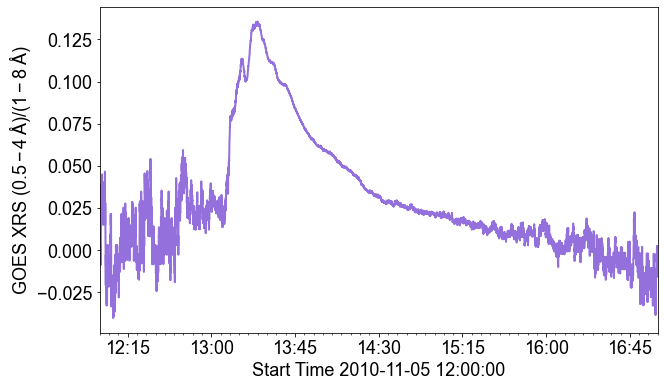

In [4]:
#  Just plot to see what ratio looks like

plt.rcParams.update({'font.size': 18,'font.family':"sans-serif",\
                         'font.sans-serif':"Arial",'mathtext.default':"regular"})

fig,ax = plt.subplots(figsize=(10, 6))
plt.plot(tg_tims,grat,marker=None,color='mediumpurple',lw=2)

ax.set_ylabel("GOES XRS $(0.5-4\;\AA)$/$(1-8\;\AA)$")
ax.set_xlabel("Start Time "+trange.start.iso[:-4])
# ax.set_yscale("log")
# ax.set_ylim([1e-9,4e-5])
ax.set_xlim([trange.start.datetime,trange.end.datetime])
# precisely control the x time labels
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=45)
minorx= matplotlib.dates.MinuteLocator(interval=5)
ax.xaxis.set_major_locator(majorx)
ax.xaxis.set_minor_locator(minorx)
ax.xaxis.set_major_formatter(myFmt)

plt.show()


In [5]:
# Temperature comes from https://hesperia.gsfc.nasa.gov/ssw/gen/idl/synoptic/goes/goes_get_chianti_temp.pro
# This is the GOES15 coronal one
r15_cor=np.array([2.43e-06,3.63e-06,5.31e-06,7.69e-06,1.11e-05,1.59e-05,2.29e-05,3.30e-05,\
   4.74e-05,6.80e-05,9.68e-05,1.36e-04,1.88e-04,2.53e-04,3.33e-04,4.29e-04,5.43e-04,\
   6.78e-04,8.39e-04,1.03e-03,1.26e-03,1.53e-03,1.84e-03,2.21e-03,2.63e-03,3.10e-03,\
   3.63e-03,4.22e-03,4.89e-03,5.62e-03,6.45e-03,7.36e-03,8.38e-03,9.51e-03,1.08e-02,\
   1.22e-02,1.37e-02,1.54e-02,1.74e-02,1.95e-02,2.19e-02,2.45e-02,2.73e-02,3.05e-02,\
   3.40e-02,3.78e-02,4.19e-02,4.65e-02,5.14e-02,5.69e-02,6.30e-02,6.97e-02,7.72e-02,\
   8.57e-02,9.53e-02,1.06e-01,1.18e-01,1.32e-01,1.47e-01,1.63e-01,1.80e-01,1.98e-01,\
   2.17e-01,2.36e-01,2.56e-01,2.76e-01,2.96e-01,3.15e-01,3.35e-01,3.54e-01,3.72e-01,\
   3.90e-01,4.08e-01,4.25e-01,4.42e-01,4.58e-01,4.73e-01,4.88e-01,5.02e-01,5.16e-01,\
   5.29e-01,5.41e-01,5.53e-01,5.64e-01,5.75e-01,5.86e-01,5.96e-01,6.05e-01,6.14e-01,\
   6.23e-01,6.31e-01,6.39e-01,6.46e-01,6.53e-01,6.60e-01,6.66e-01,6.72e-01,6.78e-01,\
   6.84e-01,6.89e-01,6.94e-01])
# Temperature bins in MK
r15_logtemp=np.arange(101)*0.02

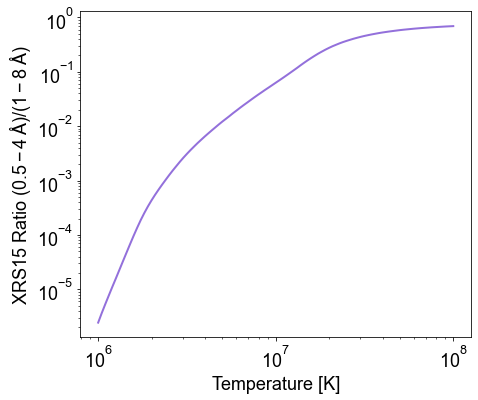

In [6]:
plt.rcParams.update({'font.size': 18,'font.family':"sans-serif",\
                         'font.sans-serif':"Arial",'mathtext.default':"regular"})

fig,ax = plt.subplots(figsize=(7, 6))
plt.plot(1e6*10**r15_logtemp,r15_cor,marker=None,color='mediumpurple',lw=2)
ax.set_ylabel("XRS15 Ratio $(0.5-4\;\AA)$/$(1-8\;\AA)$")
ax.set_xlabel("Temperature [K]")
ax.set_xscale("log")
ax.set_yscale("log")

plt.show()

In [7]:
# Example for sswidl where data ratio is 0.1 from 1e-8/1e-7
# goes_tem_calc,[1e-7,1e-8],te,em,sat=15,/chianti,remove_scaling=0
# print,te,em                                                     
#       12.2898
#    0.00439208

# sswidl uses a spline iterpolation
# numpy is just linear interpolation

print('np lin: ',10**np.interp(0.1, r15_cor, r15_logtemp))
print('np lin, lograt: ',10**np.interp(np.log10(0.1), np.log10(r15_cor), r15_logtemp))

#  sswidl version uses idl's spl_init which is a cubic spline interpolation
print('sp zero: ',10**(interpolate.interp1d(r15_cor, r15_logtemp,kind='zero'))(0.1))
print('sp sline: ',10**(interpolate.interp1d(r15_cor, r15_logtemp,kind='slinear'))(0.1))
print('sp quad: ',10**(interpolate.interp1d(r15_cor, r15_logtemp,kind='quadratic'))(0.1))
print('sp cube: ',10**(interpolate.interp1d(r15_cor, r15_logtemp,kind='cubic'))(0.1))
print('sp cube, lograt: ',10**(interpolate.interp1d(np.log10(r15_cor), r15_logtemp,kind='cubic'))(np.log10(0.1)))
# So don't need to do it in logspace when spline interpolating, 
# Not matching sswidl exactly but stil << 1% out so OK which cubic no log

np lin:  12.26831862643707
np lin, lograt:  12.275753334994828
sp zero:  12.02264434617413
sp sline:  12.26831862643707
sp quad:  12.275832643914868
sp cube:  12.27557777544164
sp cube, lograt:  12.275471768423829


In [8]:
#  So use scipy cubic spline interpolation
rat_func=interpolate.interp1d(r15_cor, r15_logtemp,kind='cubic')
# grat data can only be useful if min(r15_cor) < grat < max(r15_cor)
grat[grat < r15_cor.min()]=r15_cor.min()
grat[grat > r15_cor.max()]=r15_cor.max()
gtemps=10**rat_func(grat)

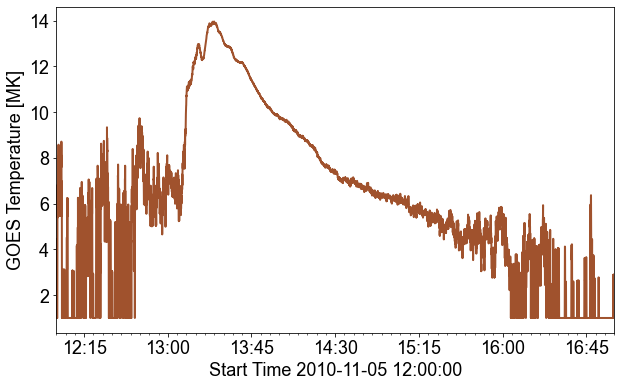

In [9]:
#  Just plot to see what ratio looks like

plt.rcParams.update({'font.size': 18,'font.family':"sans-serif",\
                         'font.sans-serif':"Arial",'mathtext.default':"regular"})

fig,ax = plt.subplots(figsize=(10, 6))
plt.plot(tg_tims,gtemps,marker=None,color='sienna',lw=2)

ax.set_ylabel("GOES Temperature [MK]")
ax.set_xlabel("Start Time "+trange.start.iso[:-4])
# ax.set_yscale("log")
# ax.set_ylim([1e-9,4e-5])
ax.set_xlim([trange.start.datetime,trange.end.datetime])
# precisely control the x time labels
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=45)
minorx= matplotlib.dates.MinuteLocator(interval=5)
ax.xaxis.set_major_locator(majorx)
ax.xaxis.set_minor_locator(minorx)
ax.xaxis.set_major_formatter(myFmt)
plt.show()

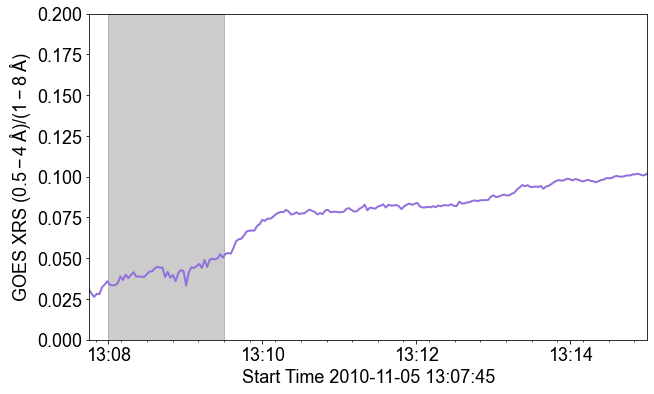

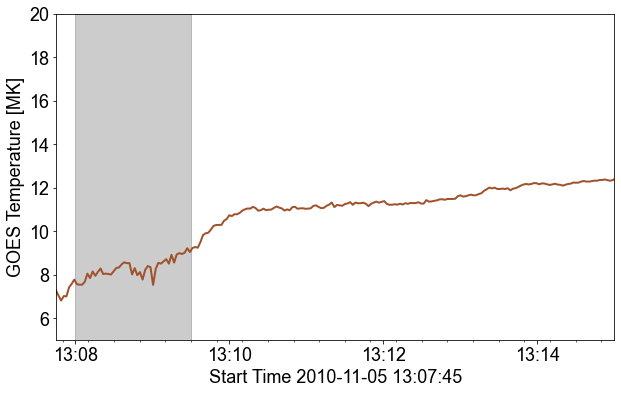

In [10]:
# Just plot range close to Fig 1 in paper
tr2=a.Time("2010-11-05 13:07:45","2010-11-05 13:15:00")
tho=a.Time("2010-11-05 13:08:00","2010-11-05 13:09:30")

fig,ax = plt.subplots(figsize=(10, 6))
plt.plot(tg_tims,grat,marker=None,color='mediumpurple',lw=2)
ax.set_ylim([0,0.2])
ax.set_ylabel("GOES XRS $(0.5-4\;\AA)$/$(1-8\;\AA)$")
ax.set_xlabel("Start Time "+tr2.start.iso[:-4])
ax.set_xlim([tr2.start.datetime,tr2.end.datetime])
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=2)
minorx= matplotlib.dates.SecondLocator(interval=20)
ax.xaxis.set_major_locator(majorx)
ax.xaxis.set_minor_locator(minorx)
ax.xaxis.set_major_formatter(myFmt)
ax.axvspan(tho.start.datetime,tho.end.datetime,color='black',alpha=0.2, label='Onset')
plt.show()


fig,ax = plt.subplots(figsize=(10, 6))
plt.plot(tg_tims,gtemps,marker=None,color='sienna',lw=2)
ax.set_ylabel("GOES Temperature [MK]")
ax.set_xlabel("Start Time "+tr2.start.iso[:-4])
ax.set_ylim([5,20])
ax.set_xlim([tr2.start.datetime,tr2.end.datetime])
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=2)
minorx= matplotlib.dates.SecondLocator(interval=20)
ax.xaxis.set_major_locator(majorx)
ax.xaxis.set_minor_locator(minorx)
ax.xaxis.set_major_formatter(myFmt)
ax.axvspan(tho.start.datetime,tho.end.datetime,color='black',alpha=0.2, label='Onset')
plt.show()

In [11]:
# Just double check in sswidl 
# goes_tem_calc,[1e-8/.04,1e-8],te,em,sat=15,/chianti,remove_scaling=0
# print,te,em
#       8.10486
#     0.0191095

# Which is the same as above

# The difference to the paper values is that they use a background subtraction?
# Yes see next cells

In [12]:
# Work out an average background level in each GOES channel from the paper time
tbck=a.Time("2010-11-05 13:06:19","2010-11-05 13:07:30")
tbckg15=g15.truncate(tbck.start.iso,tbck.end.iso)
# Work out mean for each channel
# Need to be careful that no 0, negs or NaNs in there.....
bck05=np.mean(tbckg15.quantity("xrsa").value)
bck18=np.mean(tbckg15.quantity("xrsb").value)
print(bck05,bck18)

grat_bsub=(tg_x05-bck05)/(tg_x18-bck18)
grat_bsub[grat_bsub < r15_cor.min()]=r15_cor.min()
grat_bsub[grat_bsub > r15_cor.max()]=r15_cor.max()
gtemps_bsub=10**rat_func(grat_bsub)

1.0988658e-08 5.4663786e-07


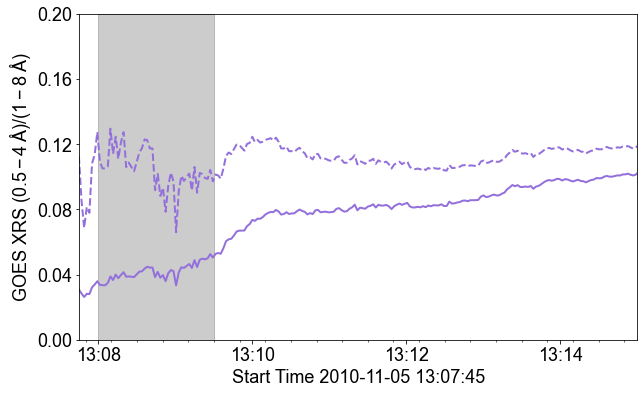

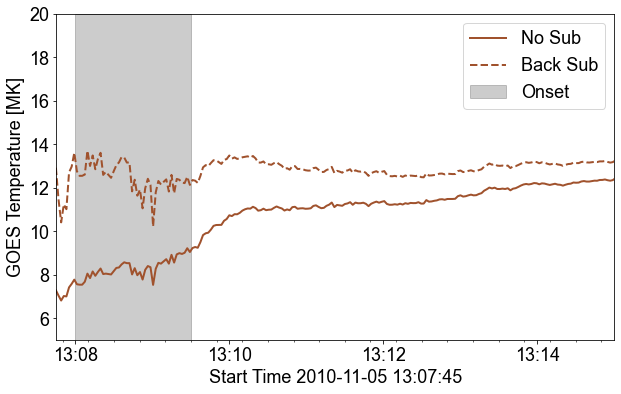

In [13]:
# Just plot range close to Fig 1 in paper
tr2=a.Time("2010-11-05 13:07:45","2010-11-05 13:15:00")
tho=a.Time("2010-11-05 13:08:00","2010-11-05 13:09:30")

fig,ax = plt.subplots(figsize=(10, 6))
plt.plot(tg_tims,grat,marker=None,color='mediumpurple',lw=2,label='No Sub')
plt.plot(tg_tims,grat_bsub,marker=None,color='mediumpurple',lw=2,ls='--',label='Back Sub')
ax.set_ylabel("GOES XRS $(0.5-4\;\AA)$/$(1-8\;\AA)$")
ax.set_xlabel("Start Time "+tr2.start.iso[:-4])
ax.set_xlim([tr2.start.datetime,tr2.end.datetime])
ax.set_ylim([0,0.2])
ax.yaxis.set_major_locator(plt.MaxNLocator(5))
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=2)
minorx= matplotlib.dates.SecondLocator(interval=20)
ax.xaxis.set_major_locator(majorx)
ax.xaxis.set_minor_locator(minorx)
ax.xaxis.set_major_formatter(myFmt)
ax.axvspan(tho.start.datetime,tho.end.datetime,color='black',alpha=0.2, label='Onset')
plt.show()

fig,ax = plt.subplots(figsize=(10, 6))
plt.plot(tg_tims,gtemps,marker=None,color='sienna',lw=2,label='No Sub')
plt.plot(tg_tims,gtemps_bsub,marker=None,color='sienna',lw=2,ls='--',label='Back Sub')
ax.set_ylabel("GOES Temperature [MK]")
ax.set_xlabel("Start Time "+tr2.start.iso[:-4])
ax.set_ylim([5,20])
ax.set_xlim([tr2.start.datetime,tr2.end.datetime])
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=2)
minorx= matplotlib.dates.SecondLocator(interval=20)
ax.xaxis.set_major_locator(majorx)
ax.xaxis.set_minor_locator(minorx)
ax.xaxis.set_major_formatter(myFmt)
ax.axvspan(tho.start.datetime,tho.end.datetime,color='black',alpha=0.2, label='Onset')
plt.legend()
plt.show()

In [14]:
# Now for the Emission Measure, which needs the actual temperature response
# which we can get from https://hesperia.gsfc.nasa.gov/ssw/gen/idl/synoptic/goes/goes_get_chianti_em.pro
# Units of this response are 1d-55*W m^-2 cm^3
tmprsp18_cor=np.array([6.27e-05,1.15e-04,2.09e-04,3.68e-04,6.29e-04,1.05e-03,1.69e-03,2.65e-03,\
    4.08e-03,6.16e-03,9.17e-03,1.35e-02,1.95e-02,2.81e-02,3.99e-02,5.61e-02,7.78e-02,\
    1.06e-01,1.43e-01,1.91e-01,2.50e-01,3.23e-01,4.11e-01,5.18e-01,6.46e-01,7.98e-01,\
    9.76e-01,1.18e+00,1.42e+00,1.70e+00,2.02e+00,2.38e+00,2.79e+00,3.24e+00,3.75e+00,\
    4.30e+00,4.92e+00,5.58e+00,6.30e+00,7.07e+00,7.90e+00,8.77e+00,9.68e+00,1.06e+01,\
    1.16e+01,1.26e+01,1.37e+01,1.47e+01,1.58e+01,1.69e+01,1.80e+01,1.91e+01,2.02e+01,\
    2.13e+01,2.23e+01,2.34e+01,2.43e+01,2.52e+01,2.61e+01,2.69e+01,2.77e+01,2.85e+01,\
    2.94e+01,3.02e+01,3.11e+01,3.20e+01,3.30e+01,3.40e+01,3.51e+01,3.62e+01,3.74e+01,\
    3.87e+01,4.00e+01,4.14e+01,4.28e+01,4.43e+01,4.58e+01,4.73e+01,4.89e+01,5.05e+01,\
    5.20e+01,5.36e+01,5.52e+01,5.68e+01,5.84e+01,5.99e+01,6.14e+01,6.28e+01,6.42e+01,\
    6.56e+01,6.69e+01,6.81e+01,6.92e+01,7.03e+01,7.12e+01,7.21e+01,7.30e+01,7.37e+01,\
    7.44e+01,7.50e+01,7.55e+01])

# Can work out the short channel response by using the earlier ratio of short/long
tmprsp05_cor=r15_cor*tmprsp18_cor

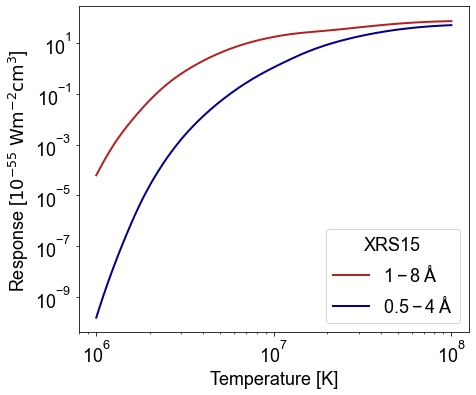

In [15]:
# Just plot them to check they are ok
plt.rcParams.update({'font.size': 18,'font.family':"sans-serif",\
                         'font.sans-serif':"Arial",'mathtext.default':"regular"})

fig,ax = plt.subplots(figsize=(7, 6))
plt.plot(1e6*10**r15_logtemp,tmprsp18_cor,marker=None,color='firebrick',lw=2,label='$1-8\;\AA$')
plt.plot(1e6*10**r15_logtemp,tmprsp05_cor,marker=None,color='darkblue',lw=2,label='$0.5-4\;\AA$')

ax.set_ylabel("Response [$\mathrm{10^{-55}\;Wm^{-2}cm^{3}}$]")
ax.set_xlabel("Temperature [K]")
ax.set_xscale("log")
ax.set_yscale("log")
plt.legend(title='XRS15')
plt.show()

In [16]:
#  So finally can work out the EM
# Interpolate not to given T to get back the response
resp18_func=interpolate.interp1d(r15_logtemp,tmprsp18_cor,kind='cubic')
lg_gtemps_bsub=np.log10(gtemps_bsub)
# Can't interpolate beyond the temp range of the response function
lg_gtemps_bsub[lg_gtemps_bsub < r15_logtemp.min()]=1e-4 #r15_logtemp.min()
lg_gtemps_bsub[lg_gtemps_bsub > r15_logtemp.max()]=r15_logtemp.max()

gem49_bsub=1e55*1e-49*(tg_x18-bck18)/resp18_func(lg_gtemps_bsub)


In [17]:
# IDL> goes_tem_calc,[1e-8/.04,1e-8],te,em,sat=15,/chianti,remove_scaling=0
# IDL> print,te,em
#       8.10486
#     0.0191095
# goes_get_chianti_em,1e-8/.04,8.10486,em,sat=15
# IDL> print,em
#    1.9111202e+47

print(1e55*(1e-8/.04)/resp18_func(np.log10(8.10486)))

1.9111202713002625e+47


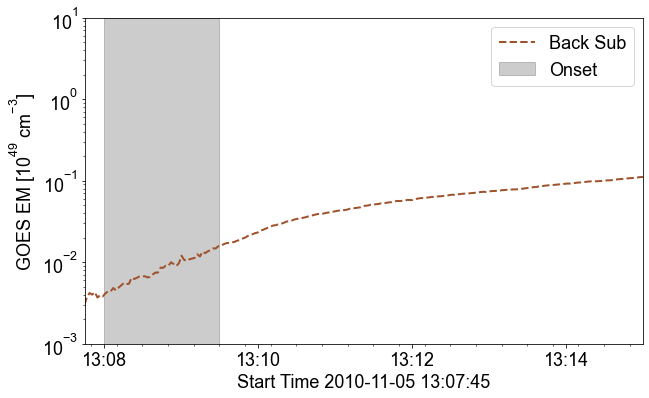

In [18]:
fig,ax = plt.subplots(figsize=(10, 6))
plt.plot(tg_tims,gem49_bsub,marker=None,color='sienna',lw=2,ls='--',label='Back Sub')
ax.set_ylabel("GOES EM [$10^{49}\;cm^{-3}$]")
ax.set_xlabel("Start Time "+tr2.start.iso[:-4])
ax.set_ylim([1e-3,1e1])
ax.set_yscale("log")
ax.set_xlim([tr2.start.datetime,tr2.end.datetime])
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=2)
minorx= matplotlib.dates.SecondLocator(interval=20)
ax.xaxis.set_major_locator(majorx)
ax.xaxis.set_minor_locator(minorx)
ax.xaxis.set_major_formatter(myFmt)
ax.axvspan(tho.start.datetime,tho.end.datetime,color='black',alpha=0.2, label='Onset')
plt.legend()
plt.show()